# Python機械学習 勉強会 第六回「教師あり学習 演習」

参考文献：  
Pythonではじめる機械学習　2章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/02-supervised-learning.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

演習データセット：  
https://www.kaggle.com/c/titanic

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split
import seaborn as sns

# 常に全ての列・列を表示
pd.options.display.max_columns = None
pd.options.display.max_rows = None

<br>

---

## はじめに

今回は以下の内容を取り組む

* 演習
    * 演習の目的
    * タスクの定義
    * データ概要
    * 評価指標
    * 探索的データ解析(exploratory data analysis: EDA)
    * 特徴量エンジニアリング
    * データ前処理
    * モデル実装
    * 評価
    * スコア向上
    
* まとめ

<br>

---

## Ex2. 演習
### Ex2-1. 演習の目的

ここではKaggleの教育用コンペ「Titanic: Machine Learning from Disaster」を例に、  
データを解析してモデルを作って予測する、といった一連の流れを掴むことを目的とする。

<br>

### Ex2-2. タスクの定義

タイタニック号のデータセットを用いて、乗客の生死を分ける要因を解析し、  
学習データをもとにモデルを構築してテストデータの乗客ごとに生死判定をする。

つまり、生死の2クラス分類となる。

<br>

### Ex2-3. データ概要

学習データには以下の特徴量が付与されている。  
* PassengerId : 乗客識別ユニークID
* Survived : 生死判定　←今回の目的変数
    * 0:死亡
    * 1:生存
* Pclass : チケットクラス
    * 1:上級クラス(金持ち)
    * 2:中級クラス(一般階級)
    * 3:下級クラス(労働階級)
* Name : 乗客の名前
* Sex : 性別
    * male:男性
    * female:女性
* Age : 年齢
* SibSp : 同乗している兄弟/配偶者の数
* parch : 同乗している親/子供の数
* ticket : チケット番号
* fare : 料金
* cabin : 客室番号
* Embarked : 出港地(タイタニックへ乗った港)

訓練データは上記特徴量から目的変数**survived**を除いたデータセット。

<br>

### Ex2-4. 評価指標の確認

今回の評価指標(モデルがどれくらい良いのか判断するための指標)は、**Accuracy**。

つまり、全体の中からどれだけ生存を生存、死亡を死亡と推論できたかを示す、
単純な評価指標が設定されてある。
* 他の評価指標に関しては、後ほどの勉強会で取り扱う

<br>

### Ex2-5. 探索的データ解析(exploratory data analysis: EDA)

良いモデルを構築するにはデータへの十分な理解が必要となる。  

最初にすべきことは、データを様々な角度から確認/解析し、  
データへの理解を深めること。

ここでは、各項目ごとに一例をしめす。  
その他さまざまな解析方法があるので、データに合わせて解析する必要がある。

<br>

#### Ex2-5-1. データの読み込み

まずは用意したデータをPandas形式で読み込む。

In [2]:
import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\answer.csv
./data\gender_submission.csv
./data\test.csv
./data\train.csv


In [3]:
train = pd.read_csv(os.path.join(dirname, 'train.csv'))
test = pd.read_csv(os.path.join(dirname, 'test.csv'))
submission = pd.read_csv(os.path.join(dirname, 'gender_submission.csv'))

<br>

### TIPS
これくらいのデータセットなら問題ないが、数十万行～からなるデータだと、  
読み込むだけでも結構な時間がかかる。
* もちろん読み込んだデータを処理するのも時間がかかる

対策として、各列の特徴に合わせて適切なデータタイプ(int16, int32, float16, など)を設定すると、
必要なメモリを削減することができる。

ここでは説明は省くが、もし実務で必要になった際は声をかけてほしい。

<br>

#### Ex2-5-2. データ形式の俯瞰
読み込んだデータを軽く眺めてみる。

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [5]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
train.shape

(891, 12)

trainは891行×12列(11個の特徴量+目的変数「Survived)

ここで数値の値そのものに意味がある数値変数は以下。
* Age
* SibSp
* Parch
* Fare

カテゴリカル変数(数値自体には意味がない=別の数値で代用可能)は以下。
* Survived
* Pclass
* Name
* Sex
* Ticket
* Cabin
* Embarked

<br>

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.29,NaN,S


In [8]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
test.shape

(418, 11)

testは418行×11列(11個の特徴量)

<br>

In [10]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [11]:
submission.shape

(418, 2)

submissionは418行×2列  

再度タスクを説明しておく。

trainをもとにモデルを構築し、構築したモデルに対して  
testを入力することで各乗客の生存判定をすること。

<br>

#### Exs2-5-3. 統計量の確認
Pandasには統計量を確認する便利な関数が用意されている。

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,20.12,0.00,0.00,7.91
50%,446.00,0.00,3.00,28.00,0.00,0.00,14.45
75%,668.50,1.00,3.00,38.00,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


In [13]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.00,418.00,332.00,418.00,418.00,417.00
mean,1100.50,2.27,30.27,0.45,0.39,35.63
std,120.81,0.84,14.18,0.90,0.98,55.91
min,892.00,1.00,0.17,0.00,0.00,0.00
25%,996.25,1.00,21.00,0.00,0.00,7.90
50%,1100.50,3.00,27.00,0.00,0.00,14.45
75%,1204.75,3.00,39.00,1.00,0.00,31.50
max,1309.00,3.00,76.00,8.00,9.00,512.33


***.describe()***を実行すると、数値特徴量の統計量を表示する。  


<br>

各データの欠損値の数・割合をチェックする。

In [14]:
def Check_missing_value(df):
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    kesson_table = pd.concat([null_val, percent], axis=1)
    kesson_table_ren_columns = kesson_table.rename(
    columns = {0 : '欠損値', 1: '%'})
    return kesson_table_ren_columns

In [15]:
Check_missing_value(train)

,欠損値,%
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,19.87
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00


In [16]:
Check_missing_value(test)

,欠損値,%
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,86,20.57
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,1,0.24
Cabin,327,78.23


<br>

#### Exs2-5-4. データ分布の確認
Pandasや、matplotlibのラッパーであるseabormなどには、  
散布図や棒グラフなどのグラフ描画機能や、相関係数を計算して表示する機能が実装されている。

C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


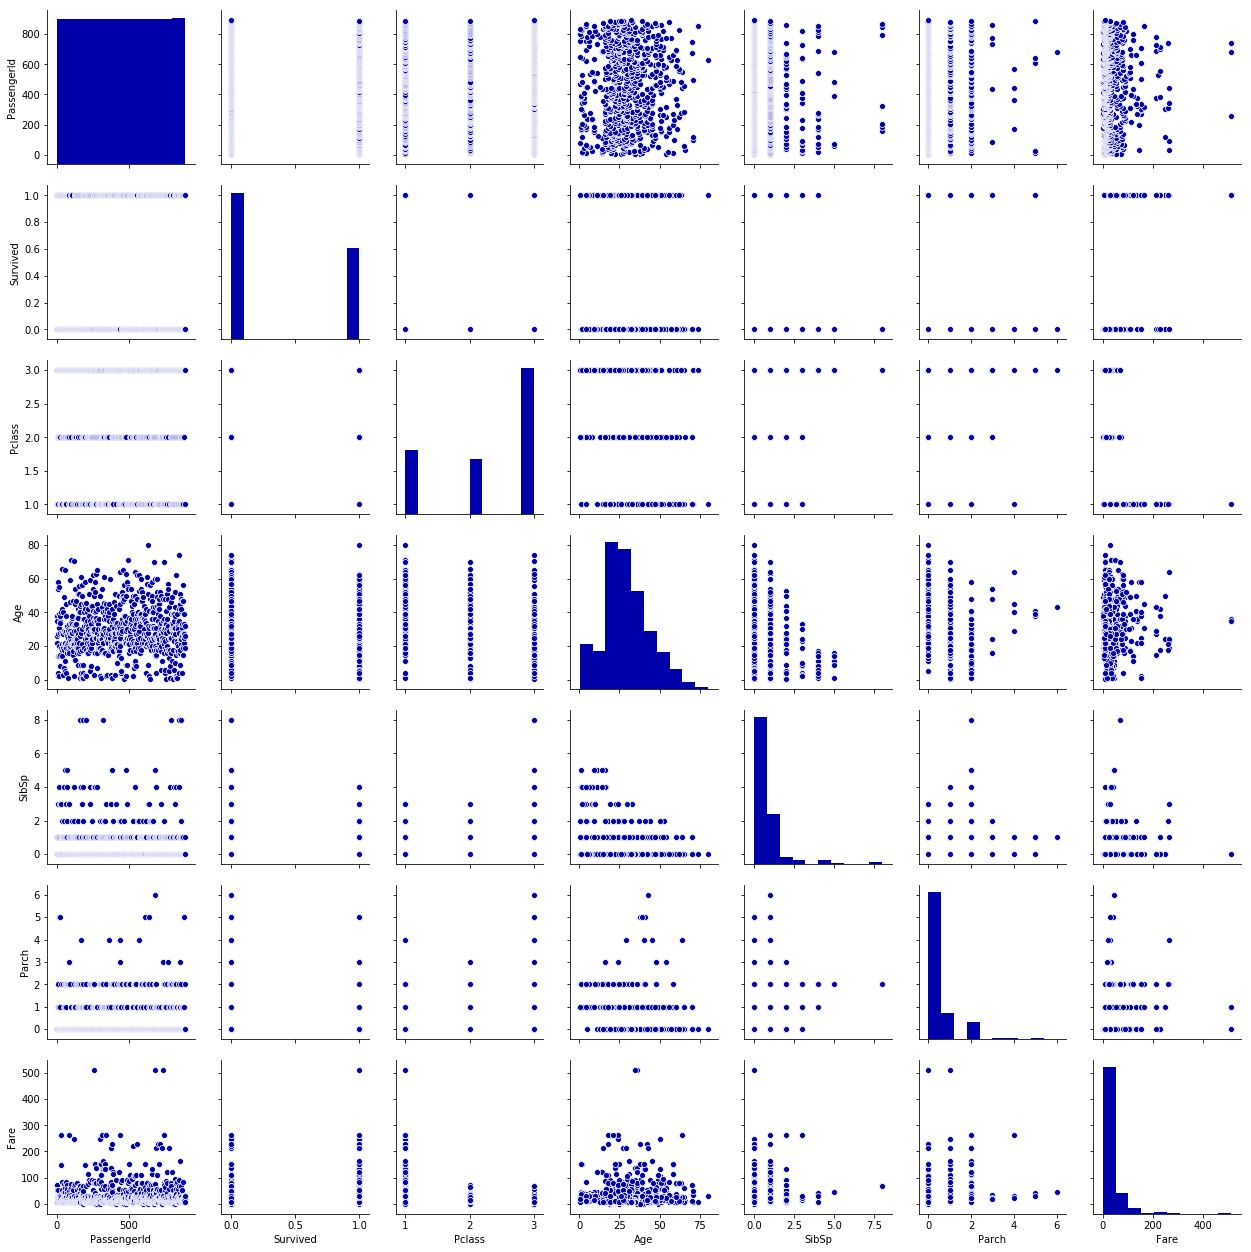

In [17]:
sns.pairplot(train)

seabornには、***.pairplot***メソッドが用意されてあり、  
入力したPandas形式データの各数値列の組み合わせごとに、散布図を描画してくれる。  
同じ特徴量同士の欄はヒストグラムが描画される。

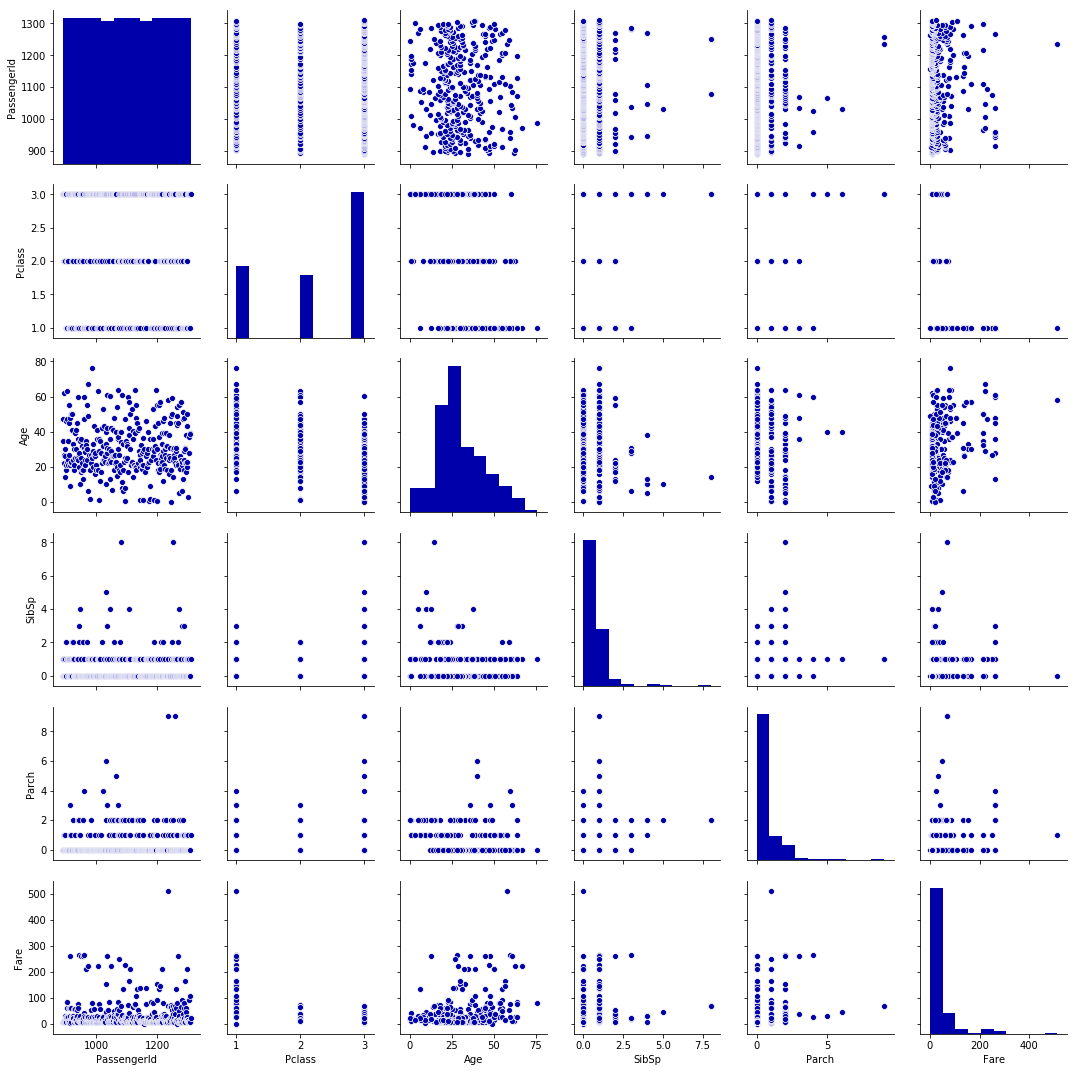

In [18]:
sns.pairplot(test)

<br>

次に、各特徴量間の相関を確認する。

In [19]:
def plot_heatmap(df):
    features = [col for col in df.columns if col]
    corr_mat = df[features].corr(method='pearson')
    
    plt.figure(figsize=[16,9])
    plt.title('train_identity')
    cmap = sns.color_palette("coolwarm", 200)
    sns.heatmap(corr_mat,
                vmin=-1.0,
                vmax=1.0,
                center=0,
                annot=True, # True:格子の中に値を表示
                fmt='.1f',
                xticklabels=corr_mat.columns.values,
                yticklabels=corr_mat.columns.values,
                cmap = cmap
               )

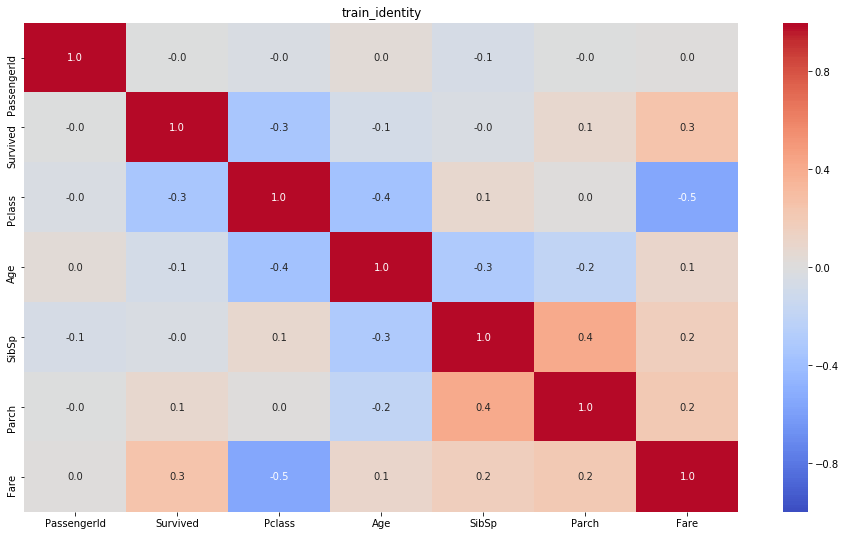

In [20]:
plot_heatmap(train)

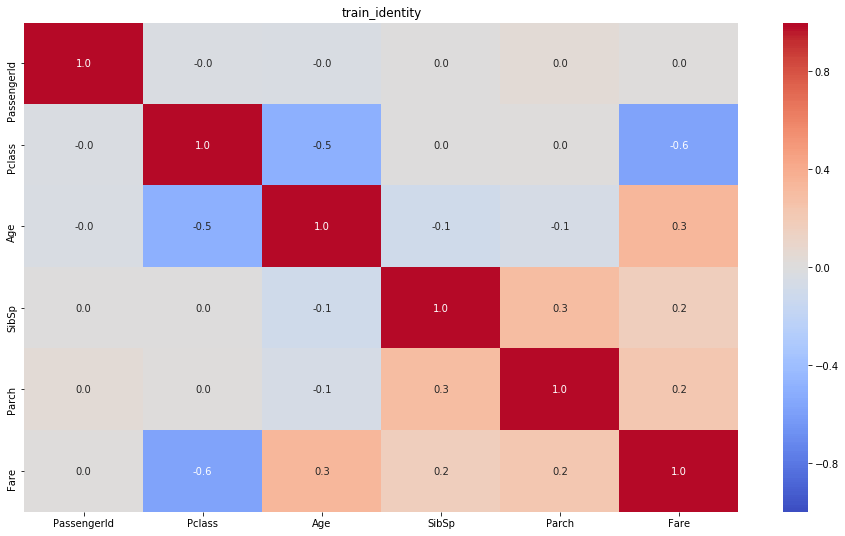

In [21]:
plot_heatmap(test)

<br>

これら以外にもデータを解析する方法は多数あるので、自分で調べて試してほしい。

<br>

### Ex2-6. 特徴量エンジニアリング
上記EDAや、もともと持っているタスクに関する知識(ドメイン知識)をもとに、  
既存の特徴量をもとに、変換したり、足し合わせたりなどして新しい特徴量をつくる。

ここでは、各自で特徴量エンジニアリングを試してほしい。

<br>

### Ex2-7. データ前処理

モデルにデータを渡す前に、モデルが解釈できるデータ形式に変換する。  
EDAの前に変換することも多い。
* カテゴリカル変数を数値データに変換して統計量をチェックする、など

<br>

また、場合によっては推論に不要と思われる情報を捨てることも必要。  
* ユニークなID、など


<br>

一般的にはモデルは数値データを解釈するので、  
文字列が入力されている特徴量は数値データに変換する。  
* Label Encoding, count encoding, one hot encoding, ...etc

<br>

また、アルゴリズムによっては特徴量間のスケールが同じでないと  
性能が落ちるものあるので、その場合はスケーリングする。   
* 正規化(平均0、分散1となるように変換), MinMax変換(0～1の間の値になるように変換), ...etc

<br>

さらには、上記EDAでもチェックしたが、アルゴリズムによってはデータに欠損値(NaN)が含まれていると、  
そもそも学習できないものもあるので、対処する必要がある。
* 平均値/最頻値/最小値/最大値/NaNであることを示す数値で埋める, 欠損値を含む行/列を削除する, ...etc

<br>

ここではそれら前処理がほとんど必要ない(というと言いすぎだが)、  
light-gbmを用いるので、文字列→数値変換のみ実施する。

おさらい。

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [23]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.29,NaN,S


<br>

### Ex2-7-1. 目的変数の設定

何を目的にして推論するのか、別の変数に設定しておく。  

In [24]:
target = train.Survived

In [25]:
print('shape of train: ', train.shape)
print('shape of target: ', target.shape)

shape of train:  (891, 12)
shape of target:  (891,)


<br>

### Ex2-7-2. 特徴量の削除

不要な特徴量を削除。  

ここでは例として、PassengerId, Name, Ticket, Embarked, Cabinなどは削除する。  

*！注意*
これらの情報が不要と断定している訳ではなく、あくまで例として削除している。  
必要な情報が抽出できそうなら、削除せずに活用してほしい。

In [26]:
train = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Embarked', 'Cabin'], axis=1)

In [27]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,22.0,1,0,7.25
1,1,female,38.0,1,0,71.28
2,3,female,26.0,0,0,7.92
3,1,female,35.0,1,0,53.10
4,3,male,35.0,0,0,8.05


In [28]:
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'], axis=1)

In [29]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.83
1,3,female,47.0,1,0,7.00
2,2,male,62.0,0,0,9.69
3,3,male,27.0,0,0,8.66
4,3,female,22.0,1,1,12.29


<br>

### Ex2-7-3. カテゴリカル変数の変換

まだ残っているカテゴリカル変数Sex, Cabinを数値に変換する。  
ここでは、各値を単純に数値に変換するLabelEncodingを用いる。
* light-gbmなどの決定木ベースのアルゴリズムであればLabelEncodingでもいいが、  
    線形モデルなどはLabelEncodingだと精度が落ちる場合があるので、  
    その場合はone hot encodingをした方がベター

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [31]:
train['Sex'] = le.fit_transform(train['Sex']).astype(np.int8)
test['Sex'] = le.fit_transform(test['Sex']).astype(np.int8)

In [32]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.25
1,1,0,38.0,1,0,71.28
2,3,0,26.0,0,0,7.92
3,1,0,35.0,1,0,53.10
4,3,1,35.0,0,0,8.05


In [33]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,34.5,0,0,7.83
1,3,0,47.0,1,0,7.00
2,2,1,62.0,0,0,9.69
3,3,1,27.0,0,0,8.66
4,3,0,22.0,1,1,12.29


In [34]:
train.dtypes

Pclass      int64
Sex          int8
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

In [35]:
test.dtypes

Pclass      int64
Sex          int8
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

<br>

これで、trainもtestも数値データたけのデータセットとなった。

<br>

### Ex2-8. モデル実装

ここまでで必要なデータがそろったのでモデル実装する。  
ここではlight-gbmで実装してみる。

In [36]:
# LightGBM
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import accuracy_score

random_state = 0

In [37]:
# 訓練セットとバリデーションセットにわける
X_train, X_test, y_train, y_test = train_test_split(
    train, target, random_state=random_state)

In [38]:
print('shape of X_train\t: ', X_train.shape)
print('shape of X_test\t\t: ', X_test.shape)
print('shape of y_train\t: ', y_train.shape)
print('shape of y_test\t\t: ', y_test.shape)

shape of X_train	:  (668, 6)
shape of X_test		:  (223, 6)
shape of y_train	:  (668,)
shape of y_test		:  (223,)


In [39]:
# LightGBM
# データセットを生成する
lgb_train = lgb.Dataset(X_train, y_train, feature_name=list(train.columns))
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM のハイパーパラメータ
lgbm_params = {
    'objective': 'binary', # 二値分類問題
    'metric': 'auc', # 評価指標「AUC」の最大化を目指す
    'verbose': -1, # 学習中の情報を表示しない。表示したい場合は1を指定。
    
    'n_estimators': 10000, # 木の数。途中で学習を終了するearly_stopping(後記)を使うので、大きい数字がいい
    'num_leaves': 50, # 1つの木の葉の最大数。2～100くらい。
    'max_depth': 7, # 木の深さの最大値。7固定。
    #'min_data_in_leaf': 70, # 1つの葉の中のデータ最小個数。1～50
    'learning_rate': 0.1, # 学習率
    'random_state': 42 # 乱数シード
}

# 上記のパラメータでモデルを学習する
lgbm = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)
y_pred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)

# しきい値 0.5 で 0, 1 に丸める
y_pred_r = np.where(y_pred > 0.5, 1, 0)

print("light-gbm auc score: {:.3f}".format(auc))
print("light-gbm accuracy score: {:.3f}".format(accuracy_score(y_test, y_pred_r)))

light-gbm auc score: 0.873
light-gbm accuracy score: 0.834


C:\Users\0060778-z100\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


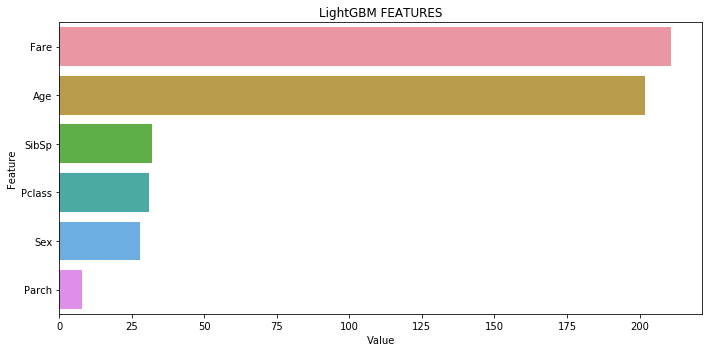

In [40]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), lgbm.feature_name()),reverse = True), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM FEATURES')
plt.tight_layout()
plt.show()

このモデルでは、FareとAgeを重要視しているらしい。

<br>

### Ex2-9. 評価

モデルの出来を評価する。

In [41]:
# 答えの用意
answer = pd.read_csv(os.path.join(dirname, 'answer.csv'))

In [42]:
answer.shape

(418, 2)

In [43]:
# 推論実施
ans_pred = lgbm.predict(test, num_iteration=lgbm.best_iteration)
ans_pred = np.where(ans_pred > 0.5, 1, 0)

In [44]:
ans_pred.shape

(418,)

答え合わせ

In [45]:
print("light-gbm accuracy score: {:.3f}".format(accuracy_score(answer.Survived, ans_pred)))

light-gbm accuracy score: 0.773


つまり、このモデルでは正答率77.3%ということ。

<br>

### Ex2-10. スコア向上

ここまでやれば、全体の処理の流れがある程度理解できたと思う。  
あとは、特徴量エンジニアリングを丁寧にやれば、さらなるスコアアップが見込める。

そのためにはデータに対する深い理解が必要なので、更にEDAを拡大したり、  
場合によってはドメイン知識を深めるために本や論文を読み、  
知見者に意見を聞いたりする施策がとられる。

ここで、そこまでやる必要はないが、自分で新たな特徴量を追加しスコア向上を目指してほしい。  

スコア向上の施策例

* 今回捨てた特徴量(PassengerId, Name, Ticket, Embarked, Cabin)をうまく活用する  
    * Cabinから脱出しやすい部屋かどうかの情報を抜き出す  
        当時の設計図から、船の下の方の部屋は脱出しにくく、  
        上の部屋は脱出しやすいかも、と考える

<br>

* 仮説を立てて検証する
    * 一緒に乗船した家族の数が関係するかもしれないので家族の数特徴量をつくる
        →家族を見捨てて逃げにくい
        * 同様に一人で乗船したかどうかの特徴量をつくる(家族の数の中でも1人を重要視する)

<br>

---

## まとめ

ここまでで、有名な教師あり学習のアルゴリズムについて一通り学び、  
また、実際にデータセットを用いてモデルを構築→評価する一連の流れを体験した。

今後は、教師なし学習アルゴリズムなどを学びつつ、  
評価指標やパラメータ最適化の方法などについても詳しく学んでいく。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。